# Injection site segmentation tutorial 
### Part of the BrainPipe package for lightsheet image processing and analysis

##### What you will need:
1. Lightsheet image directories processed through [BrainPipe](https://github.com/PrincetonUniversity/BrainPipe) or [ClearMapCluster](https://github.com/PrincetonUniversity/ClearMapCluster)
2. Paths to injection site volumes registered to atlas space 

In [2]:
#import relevant modules
import os, numpy as np, sys, matplotlib as mpl, SimpleITK as sitk
import pandas as pd, matplotlib.pyplot as plt
from skimage.external import tifffile
from collections import Counter
sys.path.append("/jukebox/wang/zahra/python/BrainPipe") #path to your copy of the BrainPipe repo
from tools.imageprocessing.orientation import fix_orientation
from tools.registration.transform import count_structure_lister, transformed_pnts_to_allen_helper_func
from tools.utils.io import makedir
plt.ion()

### Import relevant functions

##### Note: these functions will typically not need to be modified unless you are troubleshooting.

In [3]:
def orientation_crop_check(src, axes = ("0","1","2"), crop = False, dst=False):
    """Function to check orientation and cropping. MaxIPs along 0 axis.
    
      "crop": #use to crop volume, values below assume horizontal imaging and sagittal atlas
                False
                cerebellum: "[:,390:,:]"
                caudal midbrain: "[:,300:415,:]"
                midbrain: "[:,215:415,:]"
                thalamus: "[:,215:345,:]"
                anterior cortex: "[:,:250,:]"
    "dst": (optional) path+extension to save image
                
    Returns
    ---------------
    cropped image
    
    """
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    if type(src) == str: src = tifffile.imread(src)
    plt.imshow(np.max(src, axis=0))
    plt.title("Before reorientation")
    fig.add_subplot(1,2,2)
    if crop: src = eval("src{}".format(crop))
    src = fix_orientation(src, axes=axes)
    plt.imshow(np.max(src, axis=0))
    plt.title("After reorientation")
    plt.axis("off")
    if dst: plt.savefig(dst, dpi=300)
    return src

def optimize_inj_detect(src, threshold=3, filter_kernel = (3,3,3), dst=False,
                        num_sites_to_keep=1):
    """Function to test detection parameters
    
    "dst": (optional) path+extension to save image
    
    """
    if type(src) == str: src = tifffile.imread(src)
    arr = find_site(src, thresh=threshold, 
          filter_kernel=filter_kernel, num_sites_to_keep=num_sites_to_keep)*45000
    fig = plt.figure()
    fig.add_subplot(1,2,1)
    plt.imshow(np.max(arr, axis=0));  plt.axis("off")
    fig.add_subplot(1,2,2)
    plt.imshow(np.max(src, axis=0), cmap="jet");  plt.axis("off")
    
    if dst: plt.savefig(dst, dpi=300)
    
    return 

def pool_injections_for_analysis(**kwargs):
    """

    Parameters
    ----------
    **kwargs : parameter dictionary consisting of
        'inputlist' --> list of strings; path to image to be segmented
        'filter_kernel' --> tuple; 3D kernel used for segmentation in 
        (https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)
        'threshold' --> int; threshold for making final segmentation volume in find_site() function
        'num_sites_to_keep' --> int; number of segmentation sites to keep, depends on injection sites in volume
        'injectionscale' --> int; used for visualization, typically can be 45000 
        'imagescale' --> int; used for visualization, typically can be 3
        'reorientation' --> tuple of strings; reorientation for visualization, sagittal to coronal=('2','0','1'),
                            sagittal to horizontal=('2','1','0')
                            default maintains current orientation
        'crop' --> string; if volume needs to be cropped before segmentation; for cerebellum, you can typically
                    crop in y as such = '[:, 450, :]'
                    default does not crop
        'crop_atlas' --> string; if atlas needs to be cropped the same way for final 2D visualization
                         default does not crop
        'dst' --> destination directory
        'save_individual' --> boolean; if you want to save 2D image of segmentation for each brain
        'save_tif' --> boolean; if you want to save the segmented volume for each brain for later use
        'colormap' --> string; matplotlib colormap used for visualization, default is plasma
        'atlas' --> string; path to atlas file the volumes are registered to
        'annotation' --> string; path to annotation file corresponding to the atlas
        'id_table' --> annotation look-up table corresponding to the annotation volume
                        default is '/jukebox/LightSheetTransfer/atlas/allen_atlas/allen_id_table.xlsx'

    Returns
    -------
    df : pandas dataframe
        pandas dataframe of brain (column) x structures (row) of injection voxels detected

    """
    
    inputlist = kwargs["inputlist"]
    dst = kwargs["dst"]; makedir(dst)
    injscale = kwargs["injectionscale"] if "injectionscale" in kwargs else 1
    imagescale = kwargs["imagescale"] if "imagescale" in kwargs else 1
    axes = kwargs["reorientation"] if "reorientation" in kwargs else ("0","1","2")
    cmap = kwargs["colormap"] if "colormap" in kwargs else "plasma"
    id_table = kwargs["id_table"] if "id_table" in kwargs else "/jukebox/LightSheetTransfer/atlas/allen_atlas/allen_id_table.xlsx"
    save_tif = kwargs["save_tif"] if "save_tif" in kwargs else False
    num_sites_to_keep = kwargs["num_sites_to_keep"] if "num_sites_to_keep" in kwargs else 1
    nonzeros = []
    ann = sitk.GetArrayFromImage(sitk.ReadImage(kwargs["annotation"]))
    if kwargs["crop"]: ann = eval("ann{}".format(kwargs["crop"]))   
    allen_id_table=pd.read_excel(id_table)
    
    for i in range(len(inputlist)):
        impth = inputlist[i]
        animal = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(impth))))
        
        print("\n\n_______\n{}".format(animal))
        
        print("  loading:\n     {}".format(animal))
        im = tifffile.imread(impth)
            
        if kwargs["crop"]: im = eval("im{}".format(kwargs["crop"]))#; print im.shape
                
        #segment
        arr = find_site(im, thresh=kwargs["threshold"], filter_kernel=kwargs["filter_kernel"], num_sites_to_keep=num_sites_to_keep)*injscale
        if save_tif: tifffile.imsave(os.path.join(dst,"{}".format(animal)+"_inj.tif"), arr.astype("float32"))
        
        #optional "save_individual"
        if kwargs["save_individual"]:
            im = im*imagescale
            a = np.concatenate((np.max(im, axis=0), np.max(arr.astype("uint16"), axis=0)), axis=1)
            b = np.concatenate((np.fliplr(np.rot90(np.max(fix_orientation(im, axes=axes), axis=0),k=3)), np.fliplr(np.rot90(np.max(fix_orientation(arr.astype("uint16"), axes=axes), axis=0),k=3))), axis=1)
            plt.figure()
            plt.imshow(np.concatenate((b,a), axis=0), cmap=cmap, alpha=1);  plt.axis("off")
            plt.savefig(os.path.join(dst,"{}".format(animal)+".pdf"), dpi=300, transparent=True)
            plt.close()

        #cell counts to csv
        print("   finding nonzero pixels for voxel counts...")      
        nz = np.nonzero(arr)
        nonzeros.append(list(zip(*nz))) #<-for pooled image
        pos = transformed_pnts_to_allen_helper_func(np.asarray(list(zip(*[nz[2], nz[1], nz[0]]))), ann)
        tdf = count_structure_lister(allen_id_table, *pos)
        if i == 0: 
            df = tdf.copy()
            countcol = "count" if "count" in df.columns else "cell_count"
            df.drop([countcol], axis=1, inplace=True)
        df[animal] = tdf[countcol]
        
    df.to_csv(os.path.join(dst,"voxel_counts.csv"))
    print("\n\nCSV file of cell counts, saved as {}\n\n\n".format(os.path.join(dst,"voxel_counts.csv")))  
    
    #load atlas and generate final figure
    print("Generating final figure...")      
    atlas = tifffile.imread(kwargs["atlas"])
    #cropping
    #if "crop_atlas" not in kwargs:
    if kwargs["crop_atlas"]: atlas = eval("atlas{}".format(kwargs["crop_atlas"]))
        
    #condense nonzero pixels
    nzs = [str(x) for xx in nonzeros for x in xx] #this list has duplicates if two brains had the same voxel w label
    c = Counter(nzs)
    array = np.zeros_like(atlas)
    print("Collecting nonzero pixels for pooled image...")
    tick = 0
    #generating pooled array where voxel value = total number of brains with that voxel as positive
    for k,v in c.items():
        k = [int(xx) for xx in k.replace("(","").replace(")","").split(",")]
        array[k[0], k[1], k[2]] = int(v)
        tick+=1
        if tick % 50000 == 0: print("   {}".format(tick))
    
    #reslice
    atlas = fix_orientation(atlas, axes = axes)
    arr = fix_orientation(array, axes = axes)
    
    my_cmap = eval("plt.cm.{}(np.arange(plt.cm.RdBu.N))".format(cmap))
    my_cmap[:1,:4] = 0.0  
    my_cmap = mpl.colors.ListedColormap(my_cmap)
    my_cmap.set_under("w")
    plt.figure()
    plt.imshow(np.max(atlas, axis=0), cmap="gray")
    plt.imshow(np.max(arr, axis=0), alpha=0.99, cmap=my_cmap); 
    cb=plt.colorbar()
    cb.set_label("# Brains expressing", fontsize="small", labelpad=3)
    cb.ax.tick_params(labelsize="x-small")
    cb.ax.set_visible(True)
    plt.axis("off")
    plt.savefig(os.path.join(dst,"heatmap.pdf"), dpi = 300, transparent=True)
    plt.close()
    
    print("Saved as {}".format(os.path.join(dst,"heatmap.pdf")))  
        
    return df


def find_site(im, thresh=10, filter_kernel=(5,5,5), num_sites_to_keep=1):
    """Find a connected area of high intensity, using a basic filter + threshold + connected components approach
    
    by: bdeverett

    Parameters
    ----------
    img : np.ndarray
        3D stack in which to find site (technically need not be 3D, so long as filter parameter is 
        adjusted accordingly)
    thresh: float
        threshold for site-of-interest intensity, in number of standard deviations above the mean
    filter_kernel: tuple
        kernel for filtering of image before thresholding
    num_sites_to_keep: int, number of injection sites to keep, useful if multiple distinct sites
    
    Returns
    --------
    bool array of volume where coordinates where detected
    """
    from scipy.ndimage.filters import gaussian_filter as gfilt
    from scipy.ndimage import label
    if type(im) == str: im = tifffile.imread(im)

    filtered = gfilt(im, filter_kernel)
    thresholded = filtered > filtered.mean() + thresh*filtered.std() 
    labelled,nlab = label(thresholded)

    if nlab == 0:
        raise Exception("Site not detected, try a lower threshold?")
    elif nlab == 1:
        return labelled.astype(bool)
    elif num_sites_to_keep == 1:
        sizes = [np.sum(labelled==i) for i in range(1,nlab+1)]
        return labelled == np.argmax(sizes)+1
    else:
        sizes = [np.sum(labelled==i) for i in range(1,nlab+1)]
        vals = [i+1 for i in np.argsort(sizes)[-num_sites_to_keep:][::-1]]
        return np.in1d(labelled, vals).reshape(labelled.shape)

### Optimize injection detection parameters

You can check if you prefer/need to crop or reorient your volumes before running the segmentation script using `orientation_crop_check()`.

Parameters used for the function include:
* `axes` --> tuple of strings; reorientation for visualization, sagittal to coronal=('2','0','1'), sagittal to horizontal=('2','1','0'); default maintains current orientation
* `crop` -->  string; if volume needs to be cropped before segmentation; for cerebellum, you can typically crop in y as such = '[:, 450, :]' (zyx format); default does not crop; other example structures include:
    * caudal midbrain: '[:,300:415,:]'
    * midbrain: '[:,215:415,:]'
    * thalamus: '[:,215:345,:]'
    * anterior cortex: '[:,:250,:]'
    
The functions returns the cropped volume.

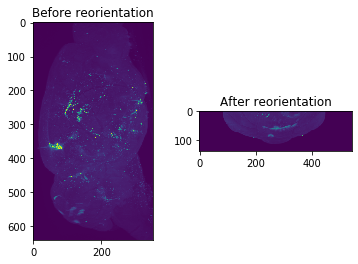

In [4]:
#check if reorientation is necessary
src = "/jukebox/wang/Jess/lightsheet_output/201904_ymaze_cfos/injection/processed/an26/elastix/an26_ymazefos_021519_1d3x_647_008na_1hfds_z10um_400msec_ch00/result.1.tif"
src = orientation_crop_check(src, axes = ("2","1","0"), crop = "[:,500:,:200]")

You can also optimize the guassian blur/thresholding to make sure the segmentation is an accurate representation of the lightsheet volume.

Parameters used for the function include:
* `src` --> cropped volume from above
* `threshold` --> int; threshold for making final segmentation volume function
* `filter_kernel` --> tuple; 3D kernel used for segmentation using the [glift](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) function
* `num_sites_to_keep` --> number of segmentation sites to save out; typically you just need one for one injection

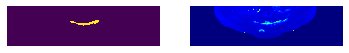

In [5]:
optimize_inj_detect(src, threshold=5, filter_kernel = (1,1,1), num_sites_to_keep=1)

### Run detection of a cohort of brains

You can run the injection site detection on multiple brains (for example, on animals belonging to the same behavioral/pertubation cohort), and get a composite figure and dataframe of the results for further analysis.

First, setup the paths to the injection channel lightsheet sheet volume registered-to-atlas in your directory structure. Note that this will defer on how you have registered the injection channel volume and the setup of your directory structure, so make sure these paths correspond to your experiement!

In [ ]:
#names of folders/animals in experiment
brains = ["an1_crus1_lat",
       "an1_vecctrl_ymaze", "an2_crus1_lat",
       "an2_vecctrl_ymaze", "an3_crus1_lat", "an3_vecctrl_ymaze",
       "an4_crus1_lat", "an4_vecctrl_ymaze", "an5_crus1_lat",
       "an5_vecctrl_ymaze", "an6_crus1_lat", "an6_vecctrl_ymaze",
       "an7_crus1_lat", "an7_vecctrl_ymaze", "an8_crus1_lat",
       "an8_vecctrl_ymaze", "an9_crus1_lat", "an9_vecctrl_ymaze",
       "an10_crus1_lat", "an10_vecctrl_ymaze", "an11_crus1_lat",
       "an12_crus1_lat", "an13_crus1_lat", "an14_crus1_lat",
       "an15_crus1_lat", "an16_crus1_lat", "an17_crus1_lat",
       "an18_crus1_lat", "an19_crus1_lat", "an20_crus1_lat"]
#path to processed folder
pth = "/jukebox/wang/Jess/lightsheet_output/202002_cfos/injection/processed"
brains = [os.path.join(pth, xx) for xx in brains]
inputlist = []
#make inputlist to injection channel lightsheet sheet volume
for brain in brains:
    reg_pth = os.path.join(pth, os.path.join(brain, "elastix"))
    inj_pth = [os.path.join(reg_pth, xx) for xx in os.listdir(reg_pth) if os.path.isdir(os.path.join(reg_pth, xx))][0]
    inputlist.append(os.path.join(inj_pth, "result.tif")) #RESULT/REGISTERED VOLUME NEEDED

Setup the parameter dictionary needed for the main run function. Possible parameters you can input include:
* `inputlist` --> list of strings; path to images to be segmented
* `filter_kernel` --> tuple; 3D kernel used for segmentation using the [glift](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html) function
* `threshold` --> int; threshold for making final segmentation volume in find_site() function
* `num_sites_to_keep` --> int; number of segmentation sites to keep, depends on injection sites in volume
* `injectionscale` --> int; used for visualization, typically can be 45000 
* `imagescale` --> int; used for visualization, typically can be 3
* `reorientation` --> tuple of strings; reorientation for visualization, sagittal to coronal=('2','0','1'), sagittal to horizontal=('2','1','0'); default maintains current orientation
* `crop` --> string; if volume needs to be cropped before segmentation; for cerebellum, you can typically crop in y as such = '[:, 450, :]'; default does not crop
* `crop_atlas` --> string; if atlas needs to be cropped the same way for final 2D visualization; default does not crop
* `dst` --> destination directory
* `save_individual` --> boolean; if you want to save 2D image of segmentation for each brain
* `save_tif` --> boolean; if you want to save the segmented volume for each brain for later use
* `colormap` --> string; matplotlib colormap used for visualization, default is plasma
* `atlas` --> string; path to atlas file the volumes are registered to
* `annotation` --> string; path to annotation file corresponding to the atlas
* `id_table` --> annotation look-up table corresponding to the annotation volume; default is `/jukebox/LightSheetTransfer/atlas/allen_atlas/allen_id_table.xlsx`

In [ ]:
kwargs = {"inputlist": inputlist, 
              "filter_kernel": (5, 5, 5),
              "threshold": 3,
              "num_sites_to_keep": 1,
              "injectionscale": 45000, 
              "imagescale": 3,
              "reorientation": ("2","0","1"),
              "crop": "[:, 450:, :]",
              "crop_atlas": "[:, 450:, :]",
              "dst": "/jukebox/wang/Jess/lightsheet_output/202002_cfos/injection/pooled_analysis",
              "save_individual": True, 
              "save_tif": True,
              "colormap": "plasma", 
              "atlas": "/jukebox/LightSheetTransfer/atlas/sagittal_atlas_20um_iso.tif",
              "annotation":"/jukebox/LightSheetTransfer/atlas/annotation_sagittal_atlas_20um_iso.tif",
              "id_table": "/jukebox/LightSheetTransfer/atlas/ls_id_table_w_voxelcounts.xlsx"
            }        

Finally, run the main function:

##### Note: the main run functions reads in several lightsheet volumes at once and performs segmentation analysis. This can typically not be done on a low power laptop, and will need a desktop with multiple cores and 8+ GB of RAM to execute successfully.

In [ ]:
df = pool_injections_for_analysis(**kwargs)

### Output

The main output, the `heatmap.pdf` figure and `voxel_counts.csv` dataframe, has the composite measures of all the brains included in the injection site analysis. `heatmap.pdf` overlays all the segmented volumes onto an atlas, and takes the maximum intensity projection to generate a 2D image:

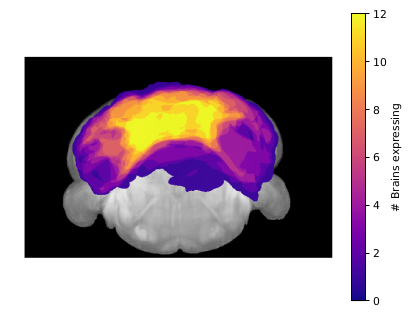